# Saving Array Quantities

## Overview

### Questions

* How can I save per-particle quantities for later analysis?
* How can I access that data?

### Objectives

* Show how to log **per-particle properties** to a **GSD** file.
* Explain how to read logged quantities from a **GSD** file.
* Mention that OVITO reads these quantities.

## Boilerplate code

In [1]:
import gsd.hoomd
import hoomd
import matplotlib
import numpy

%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
import os

fn = os.path.join(os.getcwd(), 'trajectory.gsd')
![ -e "$fn" ] && rm "$fn"

The `render` function in the next (hidden) cell will render the system state using **fresnel**.

<div class="alert alert-info">
    This is not intended as a full tutorial on <b>fresnel</b> - see the <a href="https://fresnel.readthedocs.io/">fresnel user documentation</a> if you would like to learn more.
</div>

In [3]:
import math

import fresnel
import IPython

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)


def render(snapshot):
    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(scene,
                                       N=len(snapshot.particles.position),
                                       radius=0.5)
    geometry.material = fresnel.material.Material(color=fresnel.color.linear(
        [0.01, 0.74, 0.26]),
                                                  roughness=0.5,
                                                  primitive_color_mix=1.0)
    geometry.position[:] = snapshot.particles.position[:]
    geometry.outline_width = 0.04
    energies = snapshot.log['particles/md/pair/LJ/energies']
    mapper = matplotlib.cm.ScalarMappable(
        norm=matplotlib.colors.Normalize(vmin=numpy.min(energies),
                                         vmax=numpy.max(energies),
                                         clip=True),
        cmap=matplotlib.cm.get_cmap(name='viridis'))
    geometry.color[:] = fresnel.color.linear(mapper.to_rgba(energies))

    box = fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1),
                            color=(0.8, 0.8, 0.8),
                            theta=math.pi),
        fresnel.light.Light(direction=(1, 1, 1),
                            color=(1.1, 1.1, 1.1),
                            theta=math.pi / 3)
    ]
    scene.camera = fresnel.camera.orthographic(position=(0, 0, L + 1),
                                               look_at=(0, 0, 0),
                                               up=(0, 1, 0),
                                               height=L + 1)
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

## Array quantities

You logged a 6-element array quantity in the previous section, the pressure tensor.
You can also log larger arrays and per-particle quantities (e.g. energy and force) in a **GSD** file along with the trajectory.
Then you can use utilize the data in your analysis and visualization workflow, such as using [OVITO](https://www.ovito.org/) to color particles by energy or display force vectors.
When using OVITO, open the **GSD** file and all logged quantities will be available in the inspector and for use in the pipeline.

## Define the Simulation

This tutorial executes the Lennard-Jones particle simulation from a previous tutorial. 
See [*Introducing Molecular Dyamics*](../01-Introducing-Molecular-Dynamics/00-index.ipynb) for a complete description of this code.

In [4]:
cpu = hoomd.device.CPU()
sim = hoomd.Simulation(device=cpu)
sim.create_state_from_gsd(
    filename='../01-Introducing-Molecular-Dynamics/random.gsd')

integrator = hoomd.md.Integrator(dt=0.005)
cell = hoomd.md.nlist.Cell()
lj = hoomd.md.pair.LJ(nlist=cell)
lj.params[('A', 'A')] = dict(epsilon=1, sigma=1)
lj.r_cut[('A', 'A')] = 2.5
integrator.forces.append(lj)
nvt = hoomd.md.methods.NVT(kT=1.5, filter=hoomd.filter.All(), tau=1.0)
integrator.methods.append(nvt)
sim.operations.integrator = integrator
sim.run(0)

## Logging per-particle quantities

MD forces provide a number of loggable quantities including their contribution to the system energy, but also per-particle energy contributions (in `energies`) and per-particle forces, torques, and virials.

In [5]:
lj.loggables

{'state': 'state',
 'energy': 'scalar',
 'energies': 'particle',
 'forces': 'particle',
 'torques': 'particle',
 'virials': 'particle'}

Add the per-particle LJ energies and forces to a logger:

In [6]:
logger = hoomd.logging.Logger()
logger.add(lj, quantities=['energies', 'forces'])

## Writing per-particle quantities to a GSD file

In the previous section, you used the **Null** filter to produce **GSD** file with *only* logged data.
In this section, include all particles so that you can associate logged per-particle quantities with the particle properties.


In [7]:
gsd_writer = hoomd.write.GSD(filename='trajectory.gsd',
                             trigger=hoomd.trigger.Periodic(10000),
                             mode='xb',
                             filter=hoomd.filter.All(),
                             log=logger)
sim.operations.writers.append(gsd_writer)

Run the simulation:

In [8]:
sim.run(100000)

As discussed in the previous section, delete the simulation so it is safe to open the GSD file for reading in the same process.

In [9]:
del sim, gsd_writer, logger, integrator, nvt, lj, cell, cpu

## Reading logged data from a GSD file

Use the `gsd` package to open the file:

In [10]:
traj = gsd.hoomd.open('trajectory.gsd', 'rb')

GSD prepends `particles/` to the logged name of per-particle quantities:

In [11]:
traj[0].log.keys()

dict_keys(['particles/md/pair/LJ/energies', 'particles/md/pair/LJ/forces'])

The quantities are numpy arrays with `N_particles` elements.
Here are a few slices:

In [12]:
traj[-1].log['particles/md/pair/LJ/energies'][0:10]

array([-2.21800974, -2.23550606, -2.43646589, -2.03904229, -2.26161036,
       -2.20667169, -1.46557613, -2.17635986, -2.09339117, -2.34335006])

In [13]:
traj[-1].log['particles/md/pair/LJ/forces'][0:10]

array([[ -5.62929375,  11.43326847,  18.02626974],
       [  3.63711521,  -0.38120001,   2.7978591 ],
       [ -1.15730073,  -1.557117  ,  -3.8692367 ],
       [  6.10132899,   4.70551159,  -6.13117576],
       [  5.61373405,   2.00399178,  17.71859354],
       [ -9.3845543 ,  11.03876276,  28.4841313 ],
       [  1.3228996 ,  -5.37454144,   0.37343926],
       [  6.52428281,  -2.44468769, -13.77485   ],
       [  0.77692679,  -0.63946782,   2.26389372],
       [  1.23752558,  -4.86284345,   0.1654282 ]])

You can use these arrays as inputs to any computation or plotting tools:

In [14]:
numpy.mean(traj[-1].log['particles/md/pair/LJ/forces'], axis=0)

array([ 6.93889390e-17, -1.38777878e-16,  2.68882139e-16])

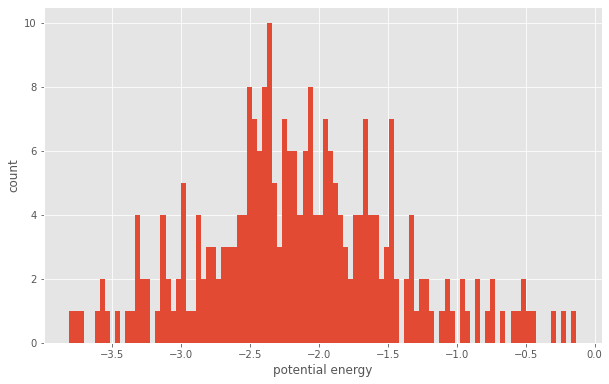

In [15]:
fig = matplotlib.figure.Figure(figsize=(10, 6.18))
ax = fig.add_subplot()
ax.hist(traj[-1].log['particles/md/pair/LJ/energies'], 100)
ax.set_xlabel('potential energy')
ax.set_ylabel('count')
fig

As with scalar quantities, the array quantities are stored separately in each frame.
Use a loop to access a range of frames and compute time-series data or averages.

This is what the system looks like when you color the particles by the values in `particles/md/pair/LJ/energies`:

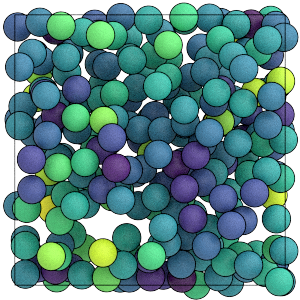

In [16]:
render(traj[-1])

In this section, you have logged per-particle quantities to a GSD file during a simulation run and accessed that data with a script.
The next section of this tutorial demonstrates how to log particle shape information that OVITO can use.

[Previous section](01-Logging-to-a-GSD-file.ipynb) / [Next section](03-Storing-Particle-Shape.ipynb)